# Forecast_LSTM

> Proyección de casos confirmados en Argentina
- toc: true
- branch: master
- badges: true
- comments: false
- author: Nicolas Santilli
- description: Time Series Forecast LSTM
- image: https://www.altumintelligence.com/assets/time-series-prediction-using-lstm-deep-neural-networks/lstm_cell.png

In [96]:
#hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

#df = pd.read_csv('AirPassengers.csv')
df_day = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
data = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv")
df_day = df_day[df_day['Country_Region'] == 'Argentina']
data = data[data['Country_Region'] == 'Argentina']
df_day = df_day[['Last_Update', 'Confirmed']]
data = data[['Last_Update', 'Confirmed']]
data = data[data['Confirmed'] > 0]
df = pd.concat([data, df_day])

In [97]:
#hide
df.Last_Update = pd.to_datetime(df.Last_Update)
df = df.set_index("Last_Update")

In [98]:
#hide
n_input = 6
train, test = df[:-n_input], df[-n_input:]

In [99]:
#hide
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [161]:
#hide
n_input = n_input
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

### Time-Series Prediction - LSTM

In [188]:
#hide_input
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [190]:
#hide
model.fit_generator(generator,epochs=90)

Epoch 1/90
5/5 [==============================] - 3s 516ms/step - loss: 0.1971
Epoch 2/90
5/5 [==============================] - 0s 19ms/step - loss: 0.1490
Epoch 3/90
5/5 [==============================] - 0s 51ms/step - loss: 0.0977
Epoch 4/90
5/5 [==============================] - 0s 12ms/step - loss: 0.0689
Epoch 5/90
5/5 [==============================] - 0s 52ms/step - loss: 0.0381
Epoch 6/90
5/5 [==============================] - 0s 38ms/step - loss: 0.0262
Epoch 7/90
5/5 [==============================] - 0s 36ms/step - loss: 0.0177
Epoch 8/90
5/5 [==============================] - 0s 17ms/step - loss: 0.0162
Epoch 9/90
5/5 [==============================] - 0s 44ms/step - loss: 0.0143
Epoch 10/90
5/5 [==============================] - 0s 16ms/step - loss: 0.0061
Epoch 11/90
5/5 [==============================] - 0s 37ms/step - loss: 0.0037
Epoch 12/90
5/5 [==============================] - 0s 21ms/step - loss: 0.0039
Epoch 13/90
5/5 [==============================] - 0s 50ms/s

### Loss

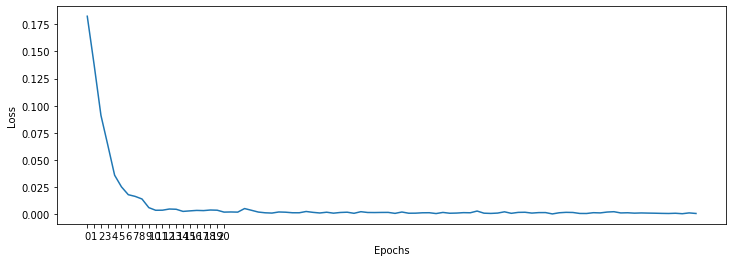

In [191]:
#hide_input
losses_lstm = model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [164]:
#hide
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [165]:
#hide
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction'])

df_test = pd.concat([df,df_predict], axis=1)

### Test

No handles with labels found to put in legend.


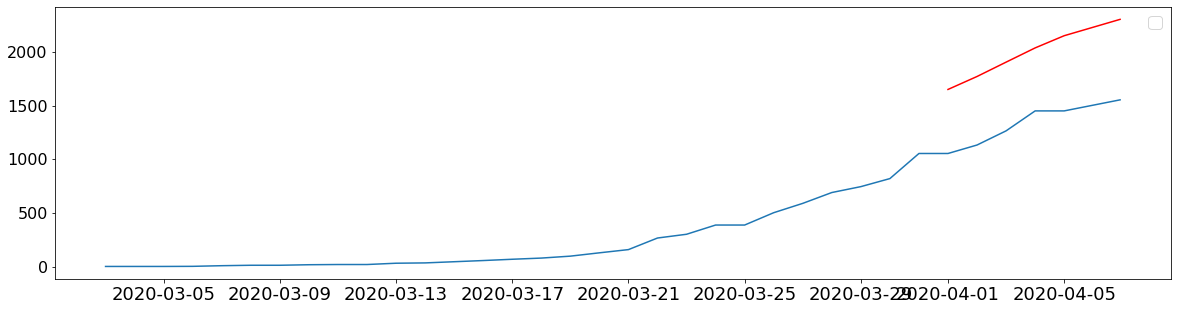

In [166]:
#hide_input
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['Confirmed'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [167]:
#hide_input
pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
print("rmse: ", pred_actual_rmse)

rmse:  [654.94856416]


In [196]:
#hide_input
df_test[-6:]

,Confirmed,Prediction
Last_Update,,
2020-04-01 00:00:00,1054,1650.927354
2020-04-02 00:00:00,1133,1771.818382
2020-04-03 00:00:00,1265,1905.527952
2020-04-04 00:00:00,1451,2038.174493
2020-04-05 00:00:00,1451,2151.895173
2020-04-06 22:11:18,1554,2304.353619


In [169]:
#hide
train = df
scaler.fit(train)
train = scaler.transform(train)

In [172]:
#hide
n_input = n_input
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [173]:
#hide
model.fit_generator(generator,epochs=90)

Epoch 1/90
5/5 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 2/90
5/5 [==============================] - 0s 41ms/step - loss: 0.0010
Epoch 3/90
5/5 [==============================] - 0s 21ms/step - loss: 0.0013
Epoch 4/90
5/5 [==============================] - 0s 43ms/step - loss: 8.2359e-04
Epoch 5/90
5/5 [==============================] - 0s 17ms/step - loss: 0.0015
Epoch 6/90
5/5 [==============================] - 0s 40ms/step - loss: 0.0011
Epoch 7/90
5/5 [==============================] - 0s 20ms/step - loss: 9.8133e-04
Epoch 8/90
5/5 [==============================] - 0s 43ms/step - loss: 0.0019
Epoch 9/90
5/5 [==============================] - 0s 18ms/step - loss: 0.0020
Epoch 10/90
5/5 [==============================] - 0s 38ms/step - loss: 0.0033
Epoch 11/90
5/5 [==============================] - 0s 22ms/step - loss: 0.0015
Epoch 12/90
5/5 [==============================] - 0s 49ms/step - loss: 0.0018
Epoch 13/90
5/5 [==============================] - 0s

In [183]:
#hide
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [184]:
#hide
from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(day=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [185]:
#hide
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([df,df_predict], axis=1)

### Proyección diaria

No handles with labels found to put in legend.


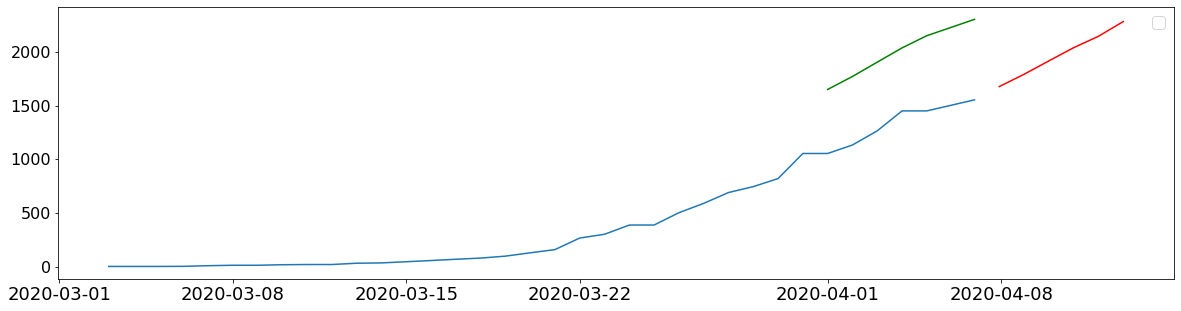

In [186]:
#hide_input
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['Confirmed'])
plt.plot(df_test.index, df_test['Prediction'], color='g')
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [187]:
#hide_input
df_predict

,Prediction
2020-04-07 22:11:18,1677.732435
2020-04-08 22:11:18,1792.521696
2020-04-09 22:11:18,1917.180347
2020-04-10 22:11:18,2040.406445
2020-04-11 22:11:18,2146.625020
2020-04-12 22:11:18,2283.759532
